# CSC8635 - The Titanic Problem
## B6030326 - Callum Simpson

### Overview of Report

This report will dissucss my solution to the Kraggle titanic problem.
I will be going over how I examined the data, cleaned it, created new featuers and got the data ready for modelling.

In this project I will also be testing diffrent types of featuer selection while using the following classifiers.

 - Logistic regression classifier
 - Random forest classifier
 - eXtreme Gradient Boosting Classifier
 - K Nearest Neighbour
 
THIS CODE MAY TAKE 20ish MINS TO RUN
 
### The problem

On the 15th of April 1912 the world famous ship the RMS Titanic unfortunately collieded into an iceberg and sank in the North Atlantic Ocean. There was an estimated 2,224 passengers and crew aboard the ship for the trip, however only 722 people survided the event and the aftermath making it one of the deadliest commercial peacetime maritime disasters in modern history.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. While there is some element of luck to if someone survided or not, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

Data has been recored about those who where on the Titanic and If they survided or not. The aim of this report will be to use this information to build a Machine learning model that will be able to accuralty predict if a person would of survided the titanic or not based on their personal information. 


## Data setup

In [759]:
# b6030326 - Callum Matthew Simpson
# This is my solution to solving the Titanic problem
#import os
#os.environ['PATH'].split(';')


# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from numpy import set_printoptions

## I have disabled warning as some of the values in my hyper pramaters sweep dosnt work togheter so it would produce a warning and continue
#import warnings
#warnings.filterwarnings('ignore')

The data provided for this project has been split into a training set and a test set.

A test data set with groundTruth was also been created for comparison at the end.

In [816]:
##Load in data


##trainning data 
train = pd.read_csv("train.csv")

##test set(with no surival classifier)
#test = pd.read_csv("D:/Masters/ML/test.csv")
test = pd.read_csv("testdata_with_groundTruth.csv")

##test data with the surivial rates of each person, This will be used at the every end to see how well my model actually makes a prediction
#test_survial = pd.read_csv("D:/Masters/ML/testdata_with_groundTruth.csv")
#col_list = ['Survived']
#test_survial = test_survial[col_list]

## Take out the Passenger ID from test(Though It will be needed later for comparision 
## I will remove it here as ID shouldnt have any effect on if a person survide or not)
TestPassengerID = test['PassengerId']


### Count of Survived     

In [817]:
print(train.groupby(['Survived']).count().iloc[:,0])

Survived
0    549
1    342
Name: PassengerId, dtype: int64


In [762]:
print(test.groupby(['Survived']).count().iloc[:,0])

Survived
0    260
1    158
Name: PassengerId, dtype: int64


## Data exploring 

In [763]:
print(train.shape)

(891, 12)


Looking at the training data we have 891 samples to work with, each with 12 features.

If we looking at the training data info we see that ...

In [764]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


we have the following featuers:

|Attribute |Description|
|----------|-----------|
|PassengerId|Unique id for each person. I dont think this will be of nay help in grouping people (so proably not needed) |
|Survived|Survival (0 = No, 1 = Yes). This will be the target variable|
|Pclass|Ticket class / the class user was in. We have 3 classes: 1st , 2nd and 3rd|
|Name|Name of the passenger (With title if they have one). We need to parse before using it.|
|Sex|Gender Categorical variable |
|SibSp|Number of Siblings / Spouses aboard the Titanic.|
|Parch|Number of Parents / Children aboard the Titanic.|
|Ticket|Ticket number|
|Fare|How much passenger paid|
|Cabin|Cabin number|
|Embarked|Port of Embarkation , C = Cherbourg, Q = Queenstown, S = Southampton|
  
What we also see is that there is missing data in the columns Age, Cabin and Embarked that we will need to look into.

This suggests that the data may be incomplete so a quick check of the test data will be done.

In [765]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


We see that there is data missing from Age ,Cabin and Fare.

If we where to combind both the training and test database we would see that...  

 - Cabin is missing 78% of its data (1 - (295 / 1309))
 - Age is missing 21% of its data (1 - (1046/1309))

It's probable that we might be able to come up with appropaite proxies for Age to fill in the NA values however due to the amount of missing data we may not be able to use Cabin without having to use some very large assumptions.  

## Exploration via graphically understanding 

In this section I will graphically exploring the features of the training data to see if there is any correlation between that feature and if a person survived or not.

### Sex

The sex of the passangers on the ship. I felt that this would be a good start to explore due to there only being 2 catergoies (male and female).

Ploting out each sex and wether they survied or not we see ...

Text(0.5, 1.0, 'Survivors by Sex')

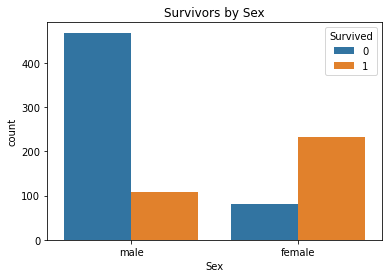

In [766]:
sns.countplot(x = 'Sex', hue = 'Survived', data = train)
plt.title('Survivors by Sex')

Text(0.5, 1.0, 'Survivors by Sex')

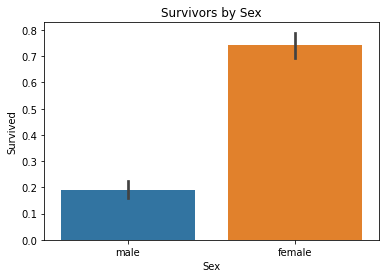

In [837]:
sns.barplot(x='Sex', y='Survived', data=train)
plt.title('Survivors by Sex')

that the Sex variable seems to be a discriminative feature. There was alot less women aboard the titanic than men however alot more females survied the disaster. Over 70% of females survided the titanic where less than %20 of males survided the titanic.

### Age

Plotting the density of age of each sex and if they survied or not we get the following 

Text(0.5, 1.0, 'How does age and sex effect survial')

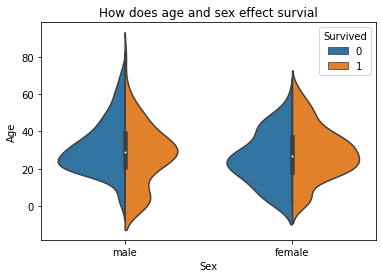

In [768]:
sns.violinplot(x = 'Sex', y = 'Age', hue = 'Survived', data = train, split = True)
plt.title('How does age and sex effect survial')

Looking at the graph we see a few things 

- younger males tended to survive than not, we also see that for the first few age years an equal amount of young females survied and died.
- Most of the people that die are between late teens and 40
- older Females tended had a higher surival rate than older males 

This suggest that age is a discriminative feature for males but maybe not as much for females. We also see that there are certian age groups that have more or less chance to survive.

This and looking at the sex survial rates we see that the phase “Women and children first!” does seem to hold.

### Pclass

The ticket class that the person belonged to could be be used to assume what social tier they belongs to, so 1st is upper 2nd is middle and 3rd may be lower.

If we do a count of how many people there where from each ticket class we can get the following

In [769]:
print(train.groupby(['Pclass']).count().iloc[:,0])

Pclass
1    216
2    184
3    491
Name: PassengerId, dtype: int64


We see that most people belonged to Pclass 3 whereas the fewest belonged to Pclass 2 

Plotting out each class and there surival rates we see the following.

Text(0.5, 1.0, 'How does Pclass effect survial')

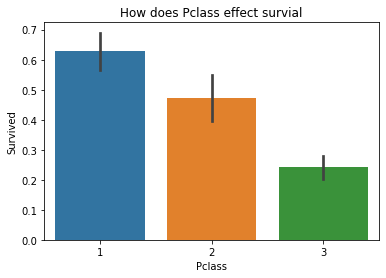

In [770]:
sns.barplot(x='Pclass', y='Survived', data=train)
plt.title('How does Pclass effect survial')

What we can see that a persons class has an effect on the probability that a person survies. The higher the ticket class the higher chance of survial. This clearly shows that PClass is a discriminative feature that could be used in our model to determin if a person survided the titanic or not.

### Name
Whilist a person birth name shouldn't have much effect on if a person lives or not. The colounm does contian a persons title so we could expect that a person with a fancy title like lord or lady to be in a higher social class than a regular Mr (and as we have seen ticket class did effect survial rates). This is somthing that I will look at later in this document.

### Cabin
As we saw cabin is missing over 78% of its data across both datasets. Whilist we might be able to work out some system to guess what room people where in there would always would be some high level of uncertianty that would come along with it. Becasue of this I have decided that I will probaly drop this value from the dataset.

### SibSp  and Parch
As both of these relate to if a person had any family aboard the Titanic I decided that I will create a new featuer using these bit of information so I will disscuss them in the featuer engineering section. 

#### SibSp 

In [ ]:
If a person is traveling alone then then have a low chance of survial

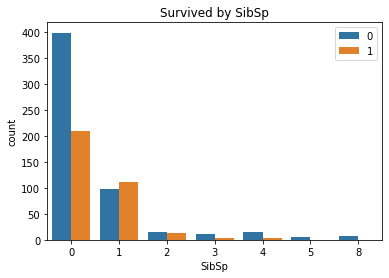

In [771]:
sns.countplot(data = train, x="SibSp", hue = "Survived").set_title("Survived by SibSp")
plt.legend(loc="upper right")

#### Parch 

If a person is traveling alone then then have a low chance of survial

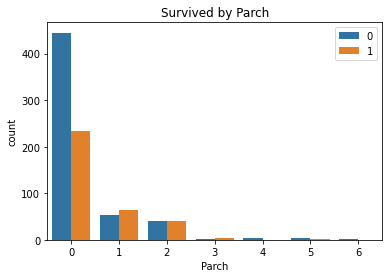

In [772]:
sns.countplot(data = train, x="Parch", hue = "Survived").set_title("Survived by Parch")
plt.legend(loc="upper right")

### Fare
We saw that people with a higher class had a higher survial rate. We would expect those with higher class tickets would have to pay more money for those tickets therefore we could assume that fare might have indercation on if a person survided or not.  

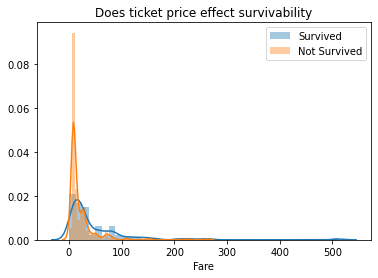

In [836]:
sns.distplot(train[train['Survived'] == 1]['Fare'], label = 'Survived')
sns.distplot(train[train['Survived'] == 0]['Fare'], label = 'Not Survived')
plt.title('Does ticket price effect survivability')
plt.legend();

Its seems like as the price a person paid for there ticket effects is they lived or not. We have alot of people how paid what seems around 10 (dollars?) who died where as those who paid more seem to have a better chance at living.

To examine how Fare effected survial rates I split Fare into 4 groups using qcut. However this lead to issues with the name of the column to throw errors. So I took the values I got from 4 groups using qcut and put them in manually with pd.cut

In [773]:
train['FareBand'] = pd.cut(train['Fare'], bins=[0, 7.91, 14.454, 31.0, 999], labels=['0_7.91', '7.91_14.454', '14.454_31.0', '31.0+'])
test['FareBand'] = pd.cut(test['Fare'] , bins=[0, 7.91, 14.454, 31.0, 999], labels=['0_7.91', '7.91_14.454', '14.454_31.0', '31.0+'])

In [774]:
print (train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean())

      FareBand  Survived
0       0_7.91  0.206731
1  7.91_14.454  0.308756
2  14.454_31.0  0.445415
3        31.0+  0.581081


The results shows that as the price of tickets go up the chance of survival goes up with it. This clearly shows that Fare is a discriminative feature. Also as 1 brand contianes 1/4 of the people we see that 50% of the passangers paid less than $14.5. This is inline with the about 50% of the passengers travelling third class.
#### Embark

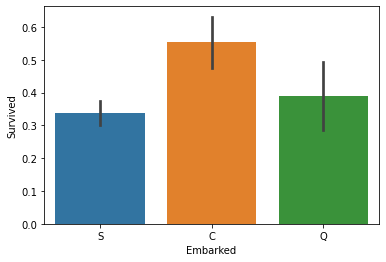

In [775]:
sns.barplot(x='Embarked', y='Survived', data=train)

Curiously we see that the port on which people boarded the ship did effect there chance of survial. Those who embarked at port C had a higher chance of survial that those from port S.

We see that Sex has the strongest correlation to survial, with Pclass being the secound. This tells us that these will be the most important when creating out classifiers. 

We see that Fare and Pclass have a stong correlation telling us that the higher the ticket price the class the person is in.

### Cleaning data

Ealier in this report we saw that Age, Cabin ,Fare and Embarked where all missing data. This section of the report will go over the cleaning process

#### Embarked and Fare

As we where only missing using one or two values for each varaible I decide for Embark I would just use the most common value (so S) and for Fare I would use the median fare value. 

In [776]:
train["Embarked"] = train["Embarked"].fillna("S") 
test["Fare"] = test["Fare"].fillna(test["Fare"].median())

#### Age

As we are missing a fair few age values I decided that I would create a bit more a thorough method to fill in the NA values so I wasnt just using the median of all ages.

I decide that I would use the median age of that persons sex and Pclass. (I wanted to do a random age between the median and + 1 / -1 sd but this added to many moving parts making reproducibility a bit more difficult

In [777]:
full_df = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

age_medians = (full_df.groupby(['Sex','Pclass'])).median()

age_medians = age_medians.reset_index()[['Sex', 'Pclass', 'Age']]

age_medians = age_medians.rename(columns= {'Age':'median'})

age_std = (full_df.groupby(['Sex','Pclass'])).std()

age_std = age_std.reset_index()[['Sex', 'Pclass', 'Age']]

age_std = age_std.rename(columns= {'Age':'std', 'Pclass':'Pclassdrop', 'Sex':'Sexdrop'})

age_fix_table = pd.concat( [age_medians, age_std ], axis=1, join="inner")
age_fix_table = age_fix_table.drop(['Pclassdrop','Sexdrop'], axis=1)
print(age_fix_table)

      Sex  Pclass  median        std
0  female       1    36.0  14.272460
1  female       2    28.0  12.911747
2  female       3    22.0  12.205254
3    male       1    42.0  14.578529
4    male       2    29.5  13.977400
5    male       3    25.0  11.682415


In [778]:
def AgeFix(row):
    Age_group = ((age_fix_table['Sex'] == row['Sex'])  & (age_fix_table['Pclass'] == row['Pclass']))
    med = age_fix_table[Age_group]['median'].values[0]
    std = age_fix_table[Age_group]['std'].values[0]
    
    #return np.random.randint(med - std, med + std)
    return med


test['Age'] = test.apply(lambda row: AgeFix(row) if np.isnan(row['Age']) else row['Age'], axis=1)
train['Age'] = train.apply(lambda row: AgeFix(row) if np.isnan(row['Age']) else row['Age'], axis=1)

We see now that the all NA values in the needed colums has been completed.

In [779]:
bigdata = pd.concat([train, test], ignore_index=True, sort=False)

print(bigdata.isnull().sum())

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
FareBand         18
dtype: int64


## Feature engineering 


### Family
As we have two variables that tell us how many people a person was traveling with (SibSp and Parch) I decieded that I could combind the two together to make one column called relatives which is how many people a person was travling with. I then wanted to streamlin that down to become a basic check if a person was or wasnt traveling with anyone.

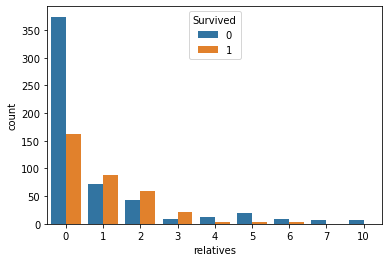

In [780]:
data = [train, test]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'alone'] = 1
    dataset['alone'] = dataset['alone'].astype(int)
    
  #  dataset['FamilySize'] = dataset['relatives'] + 1
    
   # dataset.loc[dataset['FamilySize'] == 1, 'FamType'] = "single"
   # dataset.loc[dataset['FamilySize'] > 1 , 'FamType'] = "small"
   # dataset.loc[dataset['FamilySize'] >= 5, 'FamType'] = "large"
    
    # dataset['FamType'] = dataset['FamType'].astype(str)
    
sns.countplot(x = 'relatives', hue = 'Survived', data = train)

Plotting out the number of relatives a person had with them aboard the titanic and the number that survived vs those that didnt. We see

- people who didnt have any realtives had a low chance of survival
- People with between 1 - 3 relative with them seem to have a good survial rate
- families of 4+ didnt have a good survial rate

This lead me to create two new colums called 
- SmallFamily : If a person has one to 3 relatives on the titanic
- LargeFamily: If a person had 4 more more relatives on the titanic

In [781]:
data = [train, test]
for dataset in data:
    
    dataset['SmallFamily'] = dataset['relatives'].map(lambda s: 1 if 1 <= s <= 3 else 0)
    dataset['LargeFamily'] = dataset['relatives'].map(lambda s: 1 if 4 <= s else 0)
    
#train.info()

### Titles
In the name varaible we have the peoples names which by themselves shouldnt have an impact if a person lives or not (i.e a person shouldnt have a better chance of living just because he was named "Callum"). However the name varaible does contain a persons title. Titles are normally assosiated with wealth and we saw class did effect if a person survided or not. 

I decided that I will abstract the title information to see it could be on any help.

After abstracting the titles I found out we have 18 diffrent titles in the data set. The main ones where Miss, Master, Mr Mrs. The others where either a rare title that like Dr or a alternative spelling of an actual title like Ms.

In [782]:
train_title = [i.split(",")[1].split(".")[0].strip() for i in train["Name"]]
train["Title"] = pd.Series(train_title)
test_title = [i.split(",")[1].split(".")[0].strip() for i in test["Name"]]
test["Title"] = pd.Series(test_title)

train["Title"] = train["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train["Title"] = train["Title"].map({"Master":"Master", "Miss":"Miss", "Ms" : "Mrs" , "Mme":"Miss", "Mlle":"Miss", "Mrs":"Mrs", "Mr":"Mr", "Rare":"Rare"})
test["Title"] = test["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test["Title"] = test["Title"].map({"Master":"Master", "Miss":"Miss", "Ms" : "Mrs" , "Mme":"Miss", "Mlle":"Miss", "Mrs":"Mrs", "Mr":"Mr", "Rare":"Rare"})

Text(0.5, 1.0, 'Does a person title effect survial')

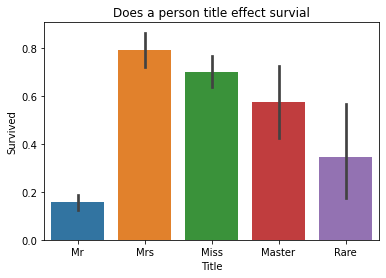

In [783]:
sns.barplot(x='Title', y='Survived', data=train)
plt.title('Does a person title effect survial')

Looking at the survial rates we see that both the female titles have a high rate of survial, 'Mr' survived alot less that the other. Master is discretized which is probaly due to the age range of people who can be classed as master (0 to 18) and how age effects survial rates. We also see that Rare was also discretized. This probaly due to the fact that we have alot of diffrent types of people in this catergory.

### Age bands

We see that a persons age effects survial so it may be benifical to combind the data into age brands. Bands worked out using qcut 6 but the way it names it variables gave me issues so I used pd.cut to cut it into bands. 

In [784]:
train['Ageband'] = pd.cut(train['Age'], bins=[0, 19, 24, 26, 32.5, 42, 999], labels=["0_19", "19_24", "24_26", "26_32.5", "32.5_42", "42+"])
test['Ageband'] = pd.cut(test['Age'], bins=[0, 19, 24, 26, 32.5, 42, 999], labels=["0_19", "19_24", "24_26", "26_32.5", "32.5_42", "42+"])
print (train[['Ageband', 'Survived']].groupby(['Ageband'], as_index=False).mean())

   Ageband  Survived
0     0_19  0.481707
1    19_24  0.412903
2    24_26  0.154412
3  26_32.5  0.414286
4  32.5_42  0.437126
5      42+  0.364341


### Preparing the data

We are now almost ready to start with the modeling, however there are a few things that need to get done first. We need to remove some varaibles from the data that we arnt planning on using (i.e name,cabin,ticket). We should also convert some of the categorical variables like Sex, Embarked ,Title and Pclass into new a series of new columns by using one hot encoding.

One hot encoding is import for machine learning with Categorical Data becasue alot of algorthims require inputs to be numeric varaibles. One hot encoding allows us to use Categorical Data which dosnt have any natural ording between categories by turning it into a each Categorical data variable into a new binary variable for each unique value in that varaible.

I will do this here by making use of python dummies.

After doing this we should have 18 featuers to work with.

https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

In [785]:
clean_test = test 
clean_train = train

clean_test = clean_test.drop(['PassengerId','Name','Cabin','Ticket','Parch','SibSp','FareBand','Ageband'],axis=1)
clean_train = clean_train.drop(['PassengerId','Name','Cabin','Ticket','Parch','SibSp','FareBand','Ageband'],axis=1)

#variable_to_one_hot  = ['Pclass', 'Sex', 'Embarked','Title','FareBand','Ageband']

#clean_test['Sex'] = clean_test['Sex'].map({'male': 0, 'female': 1}).astype(int)
#clean_train['Sex'] = clean_train['Sex'].map({'male': 0, 'female': 1}).astype(int)

variable_to_one_hot  = ['Pclass', 'Embarked','Title','Sex']

##clean_test = clean_test.drop(['PassengerId','Name','SibSp','Parch','Cabin','Ticket','FareBand'],axis=1)
##variable_to_one_hot  = ['Pclass', 'Sex', 'Embarked','Title',]

for variable in variable_to_one_hot:
    clean_test = clean_test.join(pd.get_dummies(clean_test[variable], prefix = variable))
    clean_test =clean_test.drop(variable, axis=1)
    clean_train = clean_train.join(pd.get_dummies(clean_train[variable], prefix = variable))
    clean_train =clean_train.drop(variable, axis=1)

##Scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

variable_to_scale  = ['Age', 'Fare','relatives']

clean_train[variable_to_scale] = sc.fit_transform(clean_train[variable_to_scale])
clean_test[variable_to_scale] = sc.transform(clean_test[variable_to_scale])


In [786]:
clean_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Age           891 non-null    float64
 2   Fare          891 non-null    float64
 3   relatives     891 non-null    float64
 4   alone         891 non-null    int32  
 5   SmallFamily   891 non-null    int64  
 6   LargeFamily   891 non-null    int64  
 7   Pclass_1      891 non-null    uint8  
 8   Pclass_2      891 non-null    uint8  
 9   Pclass_3      891 non-null    uint8  
 10  Embarked_C    891 non-null    uint8  
 11  Embarked_Q    891 non-null    uint8  
 12  Embarked_S    891 non-null    uint8  
 13  Title_Master  891 non-null    uint8  
 14  Title_Miss    891 non-null    uint8  
 15  Title_Mr      891 non-null    uint8  
 16  Title_Mrs     891 non-null    uint8  
 17  Title_Rare    891 non-null    uint8  
 18  Sex_female    891 non-null    

### Modelling

We now have got the data all sorted we are ready to start creating our model.

In [787]:
##all the sklearns I used or played around with


import sklearn  

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.metrics import (confusion_matrix, accuracy_score) 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from xgboost import XGBClassifier

from sklearn.ensemble import ExtraTreesClassifier

## Get the data set up
X_train = clean_train.drop("Survived", axis=1)
Y_train = clean_train["Survived"]

X_test  = clean_test.drop("Survived", axis=1)
Y_test =  clean_test["Survived"]


## Create 5 folds - StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.
K_fold = StratifiedKFold(n_splits=5)
#K_fold = 5

#### Feature selection

As we have 18 columns in our data it may be appropiate to reduce the number of featuers we are going to use to create our models to only the important ones. 

This is called featuer selection and is the process of reducing the number of input variables when developing a predictive model.

https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

It's important to do this as it will both reduce the computational cost of my creating each model and it should also improve the performance of the model. It should also help reduce any potential overfitting issues.

For my project I will be using three diffrent data frames to performe hyper-pramater turning on.

- The default data is to show comparison between it and how the featuer selection data. 

- The Feature importance method. Feature importance works by giving us a score for each feature in the data, the higher the score more important or relevant is the feature towards your output variable. Random forest will be used to determine the featuer importance for this due to its relatively good accuracy, robustness, and ease of use and should give me a subset of featuers that will reduce the chance of polluting the model.

- A recursive feature elimination with cross-validation (stepwise selection). Acesses the importance of each variable and prune the weakest feature. Rebuild the classifier and repeat until the desired number of featuers is reached. Whilist similiar to featuer selection it will not remove variables which were deemed insignificant at the beginning of the process. The cross valadation will be used on the RFE to find the optimial number of featuers.

https://www.kaggle.com/residentmario/automated-feature-selection-with-sklearn

<Figure size 576x576 with 0 Axes>

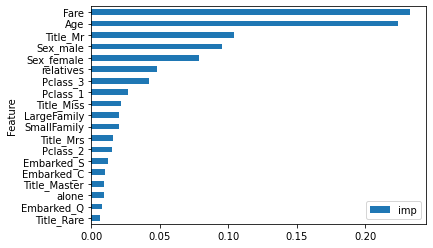

<Figure size 576x576 with 0 Axes>

In [788]:
##Featuer selection using the feature importance property of the model.
##Gives a score of each feature 

clf = RandomForestClassifier()
##clf = DecisionTreeClassifier()

clf = clf.fit(X_train, Y_train)

features = pd.DataFrame()

features['Feature'] = X_train.columns
features['imp'] = clf.feature_importances_

features.sort_values(by=['imp'], ascending = True, inplace = True)
features.set_index('Feature', inplace=True)
features.plot(kind='barh')

plt.figure(figsize=[8,8])

#### Feature importance

In [789]:
model = SelectFromModel(clf, prefit=True, threshold = 'median' )

print(model)

Importance_train_reduced = model.transform(X_train.copy())

Importance_test_reduced = model.transform(X_test.copy())

print("We started with {0} features but after featuer selection we will be using {1} of them".format(X_train.shape[1] - 1, Importance_train_reduced.shape[1]))

feature_idx = model.get_support()
Importance_feature_name = X_train.columns[feature_idx]

print(Importance_feature_name)

SelectFromModel(estimator=RandomForestClassifier(), prefit=True,
                threshold='median')
We started with 18 features but after featuer selection we will be using 10 of them
Index(['Age', 'Fare', 'relatives', 'LargeFamily', 'Pclass_1', 'Pclass_3',
       'Title_Miss', 'Title_Mr', 'Sex_female', 'Sex_male'],
      dtype='object')


#### Recursive Feature Elimination

https://machinelearningmastery.com/rfe-feature-selection-in-python/
    
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

Selected Features: [ True  True  True False False False False False  True False False False
 False False  True False  True False  True]


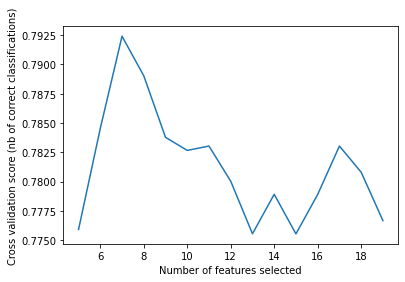

In [790]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from numpy import mean
from numpy import std

min_features_to_select = 5

#model = DecisionTreeClassifier()
##model = RandomForestClassifier()
#RFE = RFE(DecisionTreeClassifier(),n_features_to_select=10)
RFE = RFECV(DecisionTreeClassifier(),min_features_to_select=min_features_to_select , scoring='accuracy', cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1))
RFE.fit(X_train, Y_train)

print("Selected Features: %s" % (RFE.support_))

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(RFE.grid_scores_) + min_features_to_select),
         RFE.grid_scores_)
plt.show()

#print(X_train[RFE.support_])

#pipeline = Pipeline(steps=[('s',RFE),('m',model)])

#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#n_scores = cross_val_score(pipeline, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

#print('Accuracy: %.4f (%.3f)' % (mean(n_scores), std(n_scores)))

Recursive_train_reduced = pd.DataFrame(RFE.transform(X_train), columns = X_train.columns.values[RFE.support_]) 
Recursive_test_reduced = pd.DataFrame(RFE.transform(X_test), columns = X_test.columns.values[RFE.support_])

In [791]:
Recursive_train_reduced.head()

,Age,Fare,relatives,Pclass_3,Title_Mr,Title_Rare,Sex_male
0,-0.539232,-0.502445,0.059160,1.0,1.0,0.0,1.0
1,0.661032,0.786845,0.059160,0.0,0.0,0.0,0.0
2,-0.239166,-0.488854,-0.560975,1.0,0.0,0.0,0.0
3,0.435982,0.420730,0.059160,0.0,0.0,0.0,0.0
4,0.435982,-0.486337,-0.560975,1.0,1.0,0.0,1.0


In [792]:
Recursive_test_reduced.head()

,Age,Fare,relatives,Pclass_3,Title_Mr,Title_Rare,Sex_male
0,0.398474,-0.490783,-0.560975,1.0,1.0,0.0,1.0
1,1.336180,-0.507479,0.059160,1.0,0.0,0.0,0.0
2,2.461428,-0.453367,-0.560975,0.0,1.0,0.0,1.0
3,-0.164150,-0.474005,-0.560975,1.0,1.0,0.0,1.0
4,-0.539232,-0.401017,0.679295,1.0,0.0,0.0,0.0


### Tuning the selected models

In this next section I will be testing diffrent classifiers to see which works better.

I will also be extensice hyper pramater testing on each classifier. As some of my test can take a while I have set so my prediction will use the best hyper pramater set that I recived from when I did a hyper pramater sweep and have commented out the param grids used in creating the best pramater sets.  

### Score creation

In [793]:
# A methoded needed to calculate the things needed to do a proper result
def Results_metrics(conf_matrixs, name):
    
        TP = conf_matrixs[1][1]
        TN = conf_matrixs[0][0]
        FP = conf_matrixs[0][1]
        FN = conf_matrixs[1][0]

        # calculate accuracy
        accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        
         # calculate Precision
        precision = (TP / float(TP + FP))
        
        # calculate Recall
        Recall = (TP / float(TP + FN))
           
        # calculate the specificity
        specificity = (TN / float(TN + FP))

        # calculate f_1 score
        f1 = 2 * (((precision * Recall) / (precision + Recall)))
    
        df = pd.DataFrame({'Model': name , 'Accuracy': accuracy, 'Recall': Recall , 'precision' : precision,'Specificity': specificity, 'f1' : f1}, index=[0])
        
        # 'Accuracy': accuracy, 'Recall': Recall , 'precision' : precision, 'Sensitivity':sensitivity,'Specificity': specificity
        
        return df



### Receiver Operator Characteristic (ROC) and Area under Curve (AUC)

In [794]:
def Calc_ROC_AUC(classifiers, classifiers_names, Y_test, X_test, name):
    
    from sklearn.metrics import roc_curve, roc_auc_score
    ## All the points for the Roc curve
    rocs = []
    ## Store the areas under a curve
    aucs = []
    for i, j in zip(classifiers, classifiers_names):
        # get prob of each classifier
        prob = i.predict_proba(X_test)
        prob = prob[:, 1]
        
        # Calculate Roc 
        fpr, tpr, _ = roc_curve(Y_test, prob)
         # Cal AUR (Area under curve)
        auc = roc_auc_score(Y_test, prob)
        
        # Plot the ROC line onto the graph
        plt.plot(fpr, tpr, marker='.', label= j + ': AUROC = %.3f'  % auc)
    
    # Random selection
    r_probs = [0 for _ in range(len(Y_test))]
    r_auc = roc_auc_score(Y_test, r_probs)
    r_fpr, r_tpr, _ = roc_curve(Y_test, r_probs)
    plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction: AUROC = %0.3f' % r_auc)
    
    # Plot the graph
    plt.title(name + ' ROC Plot with AUC score')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend() 
    plt.show()

#### Logistic regression classifier

The first classifier I will be using to create my model is the logistic regression model.

Logistic regression is one of the core techniques for supervised learning to solve classification problems. It is used to find a relationship between featuers and find the probability of a normaly binary outcome by utilizing a logit function. 

Other Properties of Logistic Regression are:

- Estimation is done through maximum likelihood.
- Model fitness is calculated through Concordance, KS-Statistics.

Though there are many diffrent types of  Logistic Regression I will be foucusing on Binary Logistic Regression as The target variable survived has only two possible outcomes, survived or died.

https://www.kaggle.com/joparga3/2-tuning-parameters-for-logistic-regression
https://www.quora.com/What-are-some-hyperparameters-in-logistic-regression

Logistic regression dosnt have may hyperprameters to tune. The ones I will be testing are

- solver : the solver system used. The default is lbfgs however each solver type can work best under diffrent situations.
- penalty : the penalty system used to spefic what type of penalization we will be using. The default value is ’l2’.
- C : controls the penality strength must be a positive float. Smaller values specify stronger regularization. default=1.0- - max_iter : the maximum number of iterations taken for the solver to converge. The defualt is 100

Some of the hyperpramters that logisitic regression can use depened on what solver is used. I will just leave them as the defaults. There are some pramaters like max_iter that I will not be touching as It has lead to alot of over fitting issues.

There will be some warning as certian solvers cannont work with certian penalties.

In [820]:
def hyperPram_LogisticRegression(train,pramaters,Test_name , test):

    lr = LogisticRegression()

    CV_lr = GridSearchCV(estimator=lr, param_grid=pramaters, cv= K_fold, n_jobs = -1)
    
    CV_lr.fit(train,Y_train)
    
    pred = CV_lr.predict(test)

    # Confusion Matrix
    cm = confusion_matrix(Y_test, pred)

    lr_results = Results_metrics(cm , Test_name)
    
    #print(Results_metrics(cm , Test_name))
    #print('-'*20)
    
    return (lr_results,CV_lr.best_params_,CV_lr)
    

LogR_default = {'solver': ['lbfgs']} 

LogR_param_grid = { 
    'solver': ['lbfgs', 'liblinear','saga'],
    "penalty": ['l1', 'l2'],
    #"C": np.logspace(-4, 4, 20),
    "max_iter": (10,50,100,150)
}

def_log = hyperPram_LogisticRegression(X_train,LogR_default,"def_LogR",X_test)
print(def_log[0])
Imp_log = hyperPram_LogisticRegression(Importance_train_reduced,LogR_default,"Imp_LogR",Importance_test_reduced)
print(Imp_log[0])
Rec_log = hyperPram_LogisticRegression(Recursive_train_reduced,LogR_default,"Rec_LogR",Recursive_test_reduced)
#print(Rec_log[0])

def_log_hyper = hyperPram_LogisticRegression(X_train,LogR_param_grid,"def_LogR_hypP",X_test)
print(def_log_hyper[0])
Imp_log_hyper = hyperPram_LogisticRegression(Importance_train_reduced,LogR_param_grid,"Imp_LogR_hypP",Importance_test_reduced)
print(Imp_log_hyper[0])
Rec_log_hyper = hyperPram_LogisticRegression(Recursive_train_reduced,LogR_param_grid,"Rec_LogR_hypP",Recursive_test_reduced)
#print(Rec_log_hyper[0])


#Rec_log = hyperPram_LogisticRegression(Recursive_train,LogR_default,"Rec_LogR",Recursive_test)
#print(Rec_log[0])
#Rec_log_hyper = hyperPram_LogisticRegression(Recursive_train,LogR_param_grid,"Rec_LogR_hypP",Recursive_test)
#print(Rec_log_hyper[0])

      Model  Accuracy    Recall  precision  Specificity        f1
0  def_LogR  0.763158  0.727848   0.672515     0.784615  0.699088
      Model  Accuracy    Recall  precision  Specificity        f1
0  Imp_LogR  0.782297  0.727848   0.705521     0.815385  0.716511


C:\Users\Callum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


           Model  Accuracy    Recall  precision  Specificity        f1
0  def_LogR_hypP  0.770335  0.734177   0.682353     0.792308  0.707317


C:\Users\Callum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


           Model  Accuracy    Recall  precision  Specificity    f1
0  Imp_LogR_hypP  0.782297  0.740506   0.700599     0.807692  0.72


In [821]:
rfc_frames =[
def_log[0],Imp_log[0],def_log_hyper[0],Imp_log_hyper[0],Rec_log[0],Rec_log_hyper[0]]
rfc_result = pd.concat(rfc_frames)

print(rfc_result)


           Model  Accuracy    Recall  precision  Specificity        f1
0       def_LogR  0.763158  0.727848   0.672515     0.784615  0.699088
0       Imp_LogR  0.782297  0.727848   0.705521     0.815385  0.716511
0  def_LogR_hypP  0.770335  0.734177   0.682353     0.792308  0.707317
0  Imp_LogR_hypP  0.782297  0.740506   0.700599     0.807692  0.720000
0       Rec_LogR  0.784689  0.696203   0.723684     0.838462  0.709677
0  Rec_LogR_hypP  0.775120  0.702532   0.702532     0.819231  0.702532


#### Random Forest Classifier

Random Forest is another supervised learning algorithm that is capable of fitting complex datasets and performing both classification and regression tasks. It works by building a ensemble of decision trees usually trained with the bagging method. Bagging is when randomly sampling subsets of the training data are fittied to a modele of smaller data sets and then aggregating the predictions.Random Forest does this by using multiple decision trees are made and then merged together to get a more accureate and stable prediction. 

The idea behind each decision trees is to search for a pair of variable-value within the training set and split it in such a way that it would generate the best two child subsets. This is so we can create a tree where each branch on leafs are based off the optimal splitting criteria. This means each at "branch" a conditional stament would classify the data based on the fixed threshold of a variable or a set of variable critera. This will split the data up. Going down the tree each brach would split the data down further and further until a point where the data has been split up so much by  that classifaction should be possible. 

However an issue with using random forest use randoms subsets to create branches instead of trying to search for the best predictors. This adds more diversity and reduces the variance of the trees but is more bias. Another issue with random forest is that it is prone to overfit

It can be used to make predictions for categories with multiple possible values and it can be calibrated to output probabilities as well.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

The hyper pramaters I will be looking at are 

- n_estimators : number of trees in the forest. Additional decision trees typically improve model accuracy because predictions are made based on a larger number of “votes” from diverse trees, however, large numbers of trees are computationally expensive.
- max_features : Random forest models randomly resample features prior to determining the best split. Max_features determines the number of features to resample.. Higher values can lead to over-fitting but depends on case to case. Should be around 30-40% of total number of featuers
- max_depth : max number of levels in each decision tree. Used to control over-fitting as higher depth will allow model to learn relations very specific
- min_samples_split : min number of data points placed in a node before the node is split. Used to control over-fitting as higher values prevent a model from learning relations which might be highly specific but too high might lead to under fitting.
- min_samples_leaf : min number of data points allowed in a leaf node. Similar to min_samples_split as it helps combat overfitting. Generally lower values should be chosen.
- bootstrap : method for sampling data points (with or without replacement)

In [797]:

def hyperPram_RandomForest(train,pramaters,Test_name,test):

    rfc = RandomForestClassifier()
   
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=pramaters, cv= K_fold)
    CV_rfc.fit(train,Y_train)
    
    pred = CV_rfc.predict(test)

    cm = confusion_matrix(Y_test, pred)

    rfc_results = Results_metrics(cm , Test_name)
    
    return (rfc_results,CV_rfc.best_params_,CV_rfc)



In [798]:
def hyperPram_RandomForest(train,pramaters,Test_name,test):

    rfc = RandomForestClassifier()
   
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=pramaters, cv= K_fold, n_jobs = -1)
    CV_rfc.fit(train,Y_train)
    
    pred = CV_rfc.predict(test)

    cm = confusion_matrix(Y_test, pred)

    rfc_results = Results_metrics(cm , Test_name)
    
    return (rfc_results,CV_rfc.best_params_,CV_rfc)



RFC_default = {'n_estimators': [100]}

RFC_param_grid = { 
    'max_depth': [3,5,7,10],
    'criterion': ["gini", "entropy"],
    'max_features': ['auto','sqrt'],
    'min_samples_split' : [2,3],
    'min_samples_leaf' : [1,2,3],
    'n_estimators': [100,150,200,300,400],
}

def_rfc_hyper = hyperPram_RandomForest(X_train,RFC_param_grid,"def_RFC_hyp",X_test)
Imp_rfc_hyper = hyperPram_RandomForest(Importance_train_reduced,RFC_param_grid,"Imp_RFC_hyp",Importance_test_reduced)
Rec_rfc_hyper = hyperPram_RandomForest(Recursive_train_reduced,RFC_param_grid,"Rec_RFC_hyp",Recursive_test_reduced)

def_rfc = hyperPram_RandomForest(X_train,RFC_default,"def_RFC",X_test)
Imp_rfc = hyperPram_RandomForest(Importance_train_reduced,RFC_default,"Imp_RFC",Importance_test_reduced)
Rec_rfc = hyperPram_RandomForest(Recursive_train_reduced,RFC_default,"Rec_RFC",Recursive_test_reduced)

#Rec_rfc = hyperPram_RandomForest(Recursive_train,RFC_default,"Rec_RFC",Recursive_test)
#Rec_rfc_hyper = hyperPram_RandomForest(Recursive_train,RFC_param_grid,"Rec_RFC_hyp",Recursive_test)

In [799]:
frames =[
def_rfc[0],Imp_rfc[0],def_rfc_hyper[0],Imp_rfc_hyper[0]]

rfc_result = pd.concat(frames)

print(rfc_result)

         Model  Accuracy    Recall  precision  Specificity        f1
0      def_RFC  0.748804  0.677215   0.664596     0.792308  0.670846
0      Imp_RFC  0.741627  0.677215   0.652439     0.780769  0.664596
0  def_RFC_hyp  0.779904  0.708861   0.708861     0.823077  0.708861
0  Imp_RFC_hyp  0.760766  0.658228   0.693333     0.823077  0.675325


#### eXtreme Gradient Boosting Classifier 

This is a classifier that is based off gradient bossting decision trees algorthims.

Gradient boosting refers to a class of ensemble machine learning algorthim that can be used for classification or regression predictive modeling. Ensembles are constructed from decision tree models. Bossting is a ensemble machine learning model in which weak Trees are added to the ensemble one at at time and then fit to correct the prediction errors made by prior models.

The gradient boosting part comes from the fact that as the model is fit as the gradient is minized/optimised.

Gradient boosting involves three elements:

- A loss function to be optimized.
- A weak learner to make predictions.
- An additive model to add weak learners to minimize the loss function.

XGBoost is an efficient open-source implementation of the gradient boosting algorithm.

The reason I am looking at XGBoost over gradient boosting is that it applys a better regularization technique that helps reduce overfitting (so better performance) and XGBoost has been built to be faster executing than normal gradient boosting.

The hyper pramaters I will be looking at are 

- n_estimators : number of estimators (base learners). This is the number of boosting rounds.
- max_features : max number of features considered for splitting a node
- max_depth : max depth per tree. This controls how deep our tree can grow. The Larger the depth, more complex the model will be and higher chances of overfitting.
- min_samples_split : min number of data points placed in a node before the node is split
- min_samples_leaf : min number of data points allowed in a leaf node
- Learning Rate: Learning rate controls the amount of contribution that each model has on the ensemble prediction.
- subsample : The number of samples used to fit each tree. This means that each tree is fit on a randomly selected subset of the training dataset. The reason we would want to change this as using fewer samples introduces more variance for each tree but It can improve overall performance.
- max_features : The number of features used to fit each decision tree. (should check upto 30-40% of the total number of features used)

In [800]:
def hyperPram_X_grad_boost(train,pramaters,Test_name,test):

    grad_boost = XGBClassifier(verbosity = 0)

    CV_X_grad_boost = GridSearchCV(estimator=grad_boost, param_grid=pramaters, cv= K_fold, n_jobs = -1)
    CV_X_grad_boost.fit(train,Y_train)

    pred = CV_X_grad_boost.predict(test)

    # Confusion Matrix
    cm = confusion_matrix(Y_test, pred)

    CV_grad_boost_results = Results_metrics(cm , Test_name)
    
    return (CV_grad_boost_results,CV_X_grad_boost.best_params_,CV_X_grad_boost)

In [801]:
XGB_default = {'n_estimators': [100]}   
    
XGB_param_grid = { 
    'n_estimators': [50,100,200,300],
    'max_depth' : [3,5,7,10],
    "learning_rate" : [0.05,0.1,0.5],
    "subsample" : [0.1,0.3,0.5,0,7]
}

def_boost = hyperPram_X_grad_boost(X_train,XGB_default,"def_XGB",X_test)
print(def_boost[0])
Imp_boost = hyperPram_X_grad_boost(Importance_train_reduced,XGB_default,"Imp_XGB",Importance_test_reduced)
Rec_boost = hyperPram_X_grad_boost(Recursive_train_reduced,XGB_default,"Rec_XGB",Recursive_test_reduced)

def_boost_hyper = hyperPram_X_grad_boost(X_train,XGB_param_grid,"def_XGB_hyp",X_test)
Imp_boost_hyper = hyperPram_X_grad_boost(Importance_train_reduced,XGB_param_grid,"Imp_XGB_hyp",Importance_test_reduced)
Rec_boost_hyper = hyperPram_X_grad_boost(Recursive_train_reduced,XGB_param_grid,"Rec_XGB_hyp",Recursive_test_reduced)

#Rec_boost = hyperPram_X_grad_boost(Recursive_train,XGB_default,"Rec_XGB",Recursive_test)
#Rec_boost_hyper = hyperPram_X_grad_boost(Recursive_train,XGB_param_grid,"Rec_XGB_hyp",Recursive_test)

C:\Users\Callum\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


     Model  Accuracy    Recall  precision  Specificity        f1
0  def_XGB  0.748804  0.658228   0.670968     0.803846  0.664537


C:\Users\Callum\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Callum\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Callum\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of 

In [802]:
frames =[
def_boost[0],Imp_boost[0],def_boost_hyper[0],Imp_boost_hyper[0]]

X_boost_result = pd.concat(frames)

print(X_boost_result)

         Model  Accuracy    Recall  precision  Specificity        f1
0      def_XGB  0.748804  0.658228   0.670968     0.803846  0.664537
0      Imp_XGB  0.744019  0.670886   0.658385     0.788462  0.664577
0  def_XGB_hyp  0.767943  0.664557   0.704698     0.830769  0.684039
0  Imp_XGB_hyp  0.755981  0.664557   0.681818     0.811538  0.673077


#### k-Nearest Neighbor

Classifies each data point by analyzing its nearest neighbors from the training set. The current data point is assigned the class most commonly found among its neighbors

Its very simple to implement and understand and has be proven to be highlt effective for many classifcation problems. It also work well with a small number of featuers. This is important as due to featuer selection we will have a small selection to work with. However it can be somewhat computationally intensive, especially with a large training set. 

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


In [803]:
def hyperPram_k_Nearest_Neighbor(train,pramaters,Test_name,test):

    KNeighbor = KNeighborsClassifier()

    CV_KNeighbor = GridSearchCV(estimator=KNeighbor, param_grid=pramaters, cv= K_fold, n_jobs = -1)
    CV_KNeighbor.fit(train,Y_train)

    pred = CV_KNeighbor.predict(test)

    # Confusion Matrix
    cm = confusion_matrix(Y_test, pred)

    CV_KNeighbor_results = Results_metrics(cm , Test_name)
    
    return (CV_KNeighbor_results,CV_KNeighbor.best_params_,CV_KNeighbor)  

In [804]:
default = {'algorithm' : ["auto"]}   
    
param_grid = { 
    'n_neighbors': [ 3, 5, 7, 9],
     'weights' :["uniform", "distance"],
     'algorithm': ["auto", "ball_tree", "kd_tree"],
      'p' : [1,2]
}

def_k_NN = hyperPram_k_Nearest_Neighbor(X_train,default,"def_k_NN",X_test)
Imp_k_NN  = hyperPram_k_Nearest_Neighbor(Importance_train_reduced,default,"Imp_k_NN",Importance_test_reduced)
Rec_k_NN  = hyperPram_k_Nearest_Neighbor(Recursive_train_reduced,default,"Rec_k_NN",Recursive_test_reduced)

def_k_NN_hyper = hyperPram_k_Nearest_Neighbor(X_train,param_grid,"def_k_NN_hyp",X_test)
Imp_k_NN_hyper = hyperPram_k_Nearest_Neighbor(Importance_train_reduced,param_grid,"Imp_k_NN_hyp",Importance_test_reduced)
Rec_k_NN_hyper = hyperPram_k_Nearest_Neighbor(Recursive_train_reduced,param_grid,"Rec_k_NN_hyp",Recursive_test_reduced)

#Rec_k_NN  = hyperPram_k_Nearest_Neighbor(Recursive_train,default,"Rec_k_NN",Recursive_test)
#Rec_k_NN_hyper = hyperPram_k_Nearest_Neighbor(Recursive_train,param_grid,"Rec_k_NN_hyp",Recursive_test)


In [805]:
frames =[
def_k_NN[0],Imp_k_NN[0],def_k_NN_hyper[0],Imp_k_NN_hyper[0]]

k_Nearest_result = pd.concat(frames)

print(k_Nearest_result)

          Model  Accuracy    Recall  precision  Specificity        f1
0      def_k_NN  0.765550  0.708861   0.682927     0.800000  0.695652
0      Imp_k_NN  0.758373  0.677215   0.681529     0.807692  0.679365
0  def_k_NN_hyp  0.765550  0.683544   0.692308     0.815385  0.687898
0  Imp_k_NN_hyp  0.791866  0.715190   0.729032     0.838462  0.722045


#### Neural Networks

One of the issue with NN is that we need alot of data, this is somthing we dont really have in this project. I didnt have time to full utilize it

In [806]:
# Neural Network
import keras 
from keras.models import Sequential 
from keras.layers import Dense

def Neural_Networks(train,Test_name,test):

    # Initialising the NN
    model = Sequential()
    model.add(Dense(input_shape=(train.shape[1],), activation='relu', units=10))
    model.add(Dense(kernel_initializer = 'uniform', activation='relu',units=64))
    model.add(Dense(kernel_initializer = 'uniform', activation='relu', units=64))
    model.add(Dense(kernel_initializer = 'uniform', activation='sigmoid', units=1))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(train, Y_train, epochs=125, batch_size=64,verbose=0)
    
    y_pred = model.predict(test)
    y_final = (y_pred > 0.5).astype(int)
    
    fix_y_pred = []
    for i in y_final: fix_y_pred.append(i[0])
    
    # Confusion Matrix
    cm = confusion_matrix(Y_test, fix_y_pred)

    CV_NN_results = Results_metrics(cm , Test_name)
    
    return (CV_NN_results)
    
    

In [807]:
#def_NN_Nearest = Neural_Networks(X_train,"def_k_Nearest",X_test)
#Imp_NN_Nearest = Neural_Networks(Importance_train_reduced,"Imp_k_Nearestt",Importance_test_reduced)
#Rec_NN_Nearest = Neural_Networks(Recursive_train_reduced,"Rec_k_Nearest",Recursive_test_reduced)

In [808]:
#frames =[
#def_NN_Nearest,Imp_NN_Nearest,Rec_NN_Nearest]

#NN_result = pd.concat(frames)

#print(NN_result)

### Results

For my results I wanted to focus on a few things. Whilist I could and will disccuss Model Accuracy It could be possiable that it is useless due to the imbalance of survided and not sruvided data in our training set. 

Other evaluation techniques I will be looking into is.

 - Precision  : True Positives/(True Positives + False positives) The ratio of correct predicted postive observations top the total predicted postive observation. So out of the passangers we said survided how many people actuall survived. High precision relates to the low false positive rate.
 
 - Recall : True Positives/(True Positives + False Negatives) The ratio of correctly predicted positive observations to the all observations in actual class. Of all the passengers that truly survived, how many did we label correctly
 
- Specificy : (True Negative)/(True Negative + False Positive) the proportion of actual negatives, which got predicted as the negative. So the number of people who where classifiying as dying and actually died.
 
- F1 score : 2 ((Precision * Recall) / (Precision + Recall)). Its used to give a balanced between percision and the recall. F1 Score might be a better measure to use as we have an uneven class distribution (large number of Not survided to survided.).
 
- ROC AUC

### Default

In [822]:
frames =[def_log[0],def_log_hyper[0],def_rfc[0],def_rfc_hyper[0],def_boost[0],def_boost_hyper[0],def_k_NN[0],def_k_NN_hyper[0]]

Default_result = pd.concat(frames)

print(Default_result)

           Model  Accuracy    Recall  precision  Specificity        f1
0       def_LogR  0.763158  0.727848   0.672515     0.784615  0.699088
0  def_LogR_hypP  0.770335  0.734177   0.682353     0.792308  0.707317
0        def_RFC  0.748804  0.677215   0.664596     0.792308  0.670846
0    def_RFC_hyp  0.779904  0.708861   0.708861     0.823077  0.708861
0        def_XGB  0.748804  0.658228   0.670968     0.803846  0.664537
0    def_XGB_hyp  0.767943  0.664557   0.704698     0.830769  0.684039
0       def_k_NN  0.765550  0.708861   0.682927     0.800000  0.695652
0   def_k_NN_hyp  0.765550  0.683544   0.692308     0.815385  0.687898


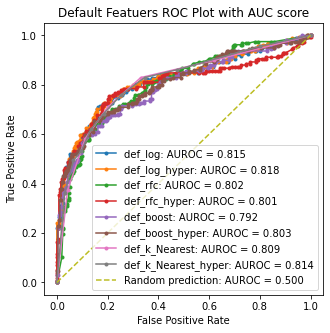

In [823]:
defaults = [def_log[2],def_log_hyper[2],def_rfc[2],def_rfc_hyper[2],def_boost[2],def_boost_hyper[2],def_k_NN[2],def_k_NN_hyper[2]]
def_name = ["def_log","def_log_hyper","def_rfc","def_rfc_hyper","def_boost","def_boost_hyper","def_k_Nearest","def_k_Nearest_hyper"]           
plt.figure(figsize=[5,5])
Calc_ROC_AUC(defaults,def_name,Y_test,X_test,"Default Featuers")

### Feature importance

In [824]:
frames =[Imp_log[0],Imp_log_hyper[0],Imp_rfc[0],Imp_rfc_hyper[0],Imp_boost[0],Imp_boost_hyper[0],Imp_k_NN[0],Imp_k_NN_hyper[0]]

k_Nearest_result = pd.concat(frames)

print(k_Nearest_result)

           Model  Accuracy    Recall  precision  Specificity        f1
0       Imp_LogR  0.782297  0.727848   0.705521     0.815385  0.716511
0  Imp_LogR_hypP  0.782297  0.740506   0.700599     0.807692  0.720000
0        Imp_RFC  0.741627  0.677215   0.652439     0.780769  0.664596
0    Imp_RFC_hyp  0.760766  0.658228   0.693333     0.823077  0.675325
0        Imp_XGB  0.744019  0.670886   0.658385     0.788462  0.664577
0    Imp_XGB_hyp  0.755981  0.664557   0.681818     0.811538  0.673077
0       Imp_k_NN  0.758373  0.677215   0.681529     0.807692  0.679365
0   Imp_k_NN_hyp  0.791866  0.715190   0.729032     0.838462  0.722045


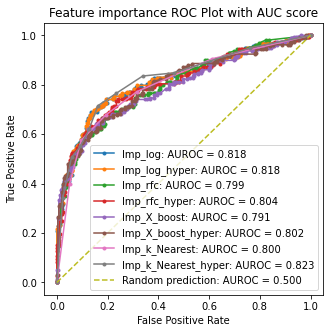

In [825]:
importance = [Imp_log[2],Imp_log_hyper[2],Imp_rfc[2],Imp_rfc_hyper[2],Imp_boost[2],Imp_boost_hyper[2],Imp_k_NN[2],Imp_k_NN_hyper[2]]
importance_name = ["Imp_log","Imp_log_hyper","Imp_rfc","Imp_rfc_hyper","Imp_X_boost","Imp_X_boost_hyper","Imp_k_Nearest","Imp_k_Nearest_hyper"]           
plt.figure(figsize=[5,5])
Calc_ROC_AUC(importance,importance_name,Y_test,Importance_test_reduced,"Feature importance")

### Recursive feature elimination with cross-validation

In [826]:
frames =[Rec_log[0],Rec_log_hyper[0],Rec_rfc[0],Rec_rfc_hyper[0],Rec_boost[0],Rec_boost_hyper[0],Rec_k_NN[0],Rec_k_NN_hyper[0]]

k_Nearest_result = pd.concat(frames)

print(k_Nearest_result)

           Model  Accuracy    Recall  precision  Specificity        f1
0       Rec_LogR  0.784689  0.696203   0.723684     0.838462  0.709677
0  Rec_LogR_hypP  0.775120  0.702532   0.702532     0.819231  0.702532
0        Rec_RFC  0.729665  0.645570   0.641509     0.780769  0.643533
0    Rec_RFC_hyp  0.767943  0.664557   0.704698     0.830769  0.684039
0        Rec_XGB  0.739234  0.658228   0.654088     0.788462  0.656151
0    Rec_XGB_hyp  0.767943  0.658228   0.707483     0.834615  0.681967
0       Rec_k_NN  0.758373  0.658228   0.688742     0.819231  0.673139
0   Rec_k_NN_hyp  0.763158  0.670886   0.692810     0.819231  0.681672


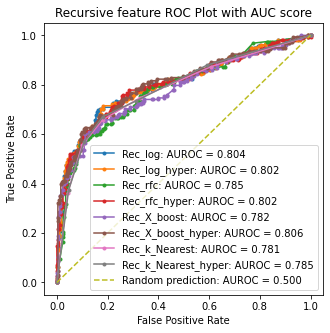

In [828]:
Recursive = [Rec_log[2],Rec_log_hyper[2],Rec_rfc[2],Rec_rfc_hyper[2],Rec_boost[2],Rec_boost_hyper[2],Rec_k_NN[2],Rec_k_NN_hyper[2]]
Recursive_name = ["Rec_log","Rec_log_hyper","Rec_rfc","Rec_rfc_hyper","Rec_X_boost","Rec_X_boost_hyper","Rec_k_Nearest","Rec_k_Nearest_hyper"]          
plt.figure(figsize=[5,5])
Calc_ROC_AUC(Recursive,Recursive_name,Y_test,Recursive_test_reduced,"Recursive feature")

### Disscussion

We have ran a number of models and all have returned a number of diffrent results. 

As aim of this report will be to use this information to build a Machine learning model that will be able to accuralty predict if a person would of survided the titanic or not based on their personal information, I feel like we have discovered the key groups that help us classify if a person survided the titanic or not. 
   
We see that both feature selections have deemed that the biggest factors to wether a person would or would not to survie the titanic where if you where a MR (so an older adult male), Had a rare tile ,in PClass 3 or came from a family that 4 or more relatives. 

If I where to ask the question if I would survie the titanic I probaly wouldnt as Im a 22 year old male (who probably wouldnt be in first class) so the I neatly fall into the featuers that have been deemed the most importnat to deciding if someone would of not survided. If I was in first class then my chances of living would increase slightly. If I was 8 and from first class and from a small family then my chances of living goes up alot more so I probaly would of survided the disastor.

However it should be said that none of my models scored 100% and all got high 70s suggesting that whilist some groups did have a higher chance of surving than others we assume that there was some element of luck invloved or there are some other factors that where invovled that where not taken into account/recorded. 

Personally I see survial of the titanic in two stages.

The 1st would be making it onto the life boats. One of the things that made the Titanic as big of a disastors as it was the fact that there wasnt enough life boats for everyone on board couple that with the fact that all the life boats left before the they reach maxium capity ment that there was alot of people who didnt make it onto a life boat. If a person made it onto a life boat then they where safe. Whilist we dont know from this database who excatly made it onto a life boat the phrase "woman and children first" comes to mind and when we explorded the training data we find did find that the data fits this assumption. We saw that Children of both genders had a high survial rate and that when compared to men, woman had a higher chance of survial suggesting that most of the people in these groups where on the life boats. However not all life boats where filled so its possiable that some people who fit this critea didnt make it onto a boat and its also possiable that some males would have made it onto a life boat (so people from a group of people who have a low chance of surving survided) 


The 2nd survial stage would be then people who didnt make it onto a lifeboat but where able to surive long enough for a rescue craft to survie. Whilist making it onto a life boat seems to depend on the Sex and Age of the person surving a shinking ship may require more factors to determin if that person survided thats not quantified in the database. Its also possasble that its cant be factorised and may they may just survided based on luck. 



### Conclusion

In Conclusion I feel like that you can create a model using this data that would predit if a given person would of survided the titanic however it could never be perfect and would only ever be a base level prediction. Whilist its easy now to look over the data and see that certian groups of people had a higher change of survial you have to imagin the of fear and panic of the people during the sinking. People would of done what they could to protect them selfs and help those around them, meaning that there are mabye hundreds of thousands of reasosns to why a person did or didnt surive the Titanic that we simply will not know and will never be able to factories. Some of which might just be luck.       



In [815]:
#### The following a section of code that i might remove, its basically just a test that 